In [15]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [16]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [17]:
torch.backends.cudnn.benchmark=True

## Data

In [18]:
PATH = Path('../data/Train')

In [19]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [20]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [285]:
S_PREFIX = '96-crop'

### Create dataloader

In [22]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img[:,:,2]==VEHICLES] = 1
    # yv = y_img[:,:,2]==VEHICLES
    cutoff_y = int(y_new.shape[0]*.83)
    y_new[cutoff_y:,:,:] = 0

    y_new[y_img[:,:,2]==ROADS] = 2
    y_new[y_img[:,:,2]==ROAD_LINES] = 2
    return y_new

In [126]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
#             return im
            return convert_y(im)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [196]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 2
#     def get(self, tfm, x, y):
#         x,y = super().get(tfm, x, y)
#         print(y.shape)
#         return x,y

In [333]:
def crop_bg(x, y):
#     print(x.shape)
    # Original
    top = int(x.shape[0]/3)
#     bot = int(x.shape[0]*.86)
    bot = x.shape[0]


#     top = int(x.shape[0]/4)
#     bot = int(x.shape[0]*.9)
#     print(top, bot, x.shape)
    x,y = x[top:bot,:,:],y[top:bot,:,:]
#     print(y.shape)
    return x,y
    

In [334]:

class RC(CoordTransform):
    """ A class that represents a Random Crop transformation.

    This transforms (optionally) transforms x,y at with the same parameters.
    Arguments
    ---------
        targ: int
            target size of the crop.
        tfm_y: TfmType
            type of y transformation.
    """
    def __init__(self, targ_sz, tfm_y=TfmType.NO, sz_y=None):
        super().__init__(tfm_y)
        self.targ_sz,self.sz_y = targ_sz,sz_y

    def set_state(self):
        self.store.rand_r = random.uniform(0, 1)
        self.store.rand_c = random.uniform(0, 1)

    def do_transform(self, x, is_y):
        r,c,*_ = x.shape
        sz = self.sz_y if is_y else self.targ_sz
        start_r = np.floor(self.store.rand_r*(r-sz)).astype(int)
        start_c = np.floor(self.store.rand_c*(c-sz)).astype(int)
        res = crop(x, start_r, start_c, sz)
        return res

In [335]:
def get_data(train_path, mask_path, bs, size):
    x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
    y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
    val_idxs = list(range(100))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    aug_tfms = [
        crop_bg,
        RandomScale(sz, 1.1, tfm_y=TfmType.CLASS, sz_y=sz),
        RC(sz, tfm_y=TfmType.CLASS, sz_y=sz),
        RandomRotate(4, tfm_y=TfmType.CLASS),
        RandomFlip(tfm_y=TfmType.CLASS),
        RandomLighting(0.05, 0.1, tfm_y=TfmType.CLASS)
    ]
    tfms = tfms_from_model(resnet34, size, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms, scale=[])
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
    denorm = md.trn_ds.denorm
    return md

In [336]:
TRAIN_DN = 'CameraRGB-150'
MASKS_DN = 'CameraSeg-150'
sz = 96
targ_sz = 96
bs = 2
md = get_data(TRAIN_DN, MASKS_DN, bs, sz)

In [337]:
md.trn_ds.transform

[<function crop_bg at 0x7f13e1875378>, <fastai.transforms.RandomScale object at 0x7f134c21b198>, <__main__.RC object at 0x7f134c21b9e8>, <fastai.transforms.RandomRotate object at 0x7f134c21b7f0>, <fastai.transforms.RandomFlip object at 0x7f134c21bcf8>, <fastai.transforms.RandomLighting object at 0x7f134c21b208>, <fastai.transforms.NoCrop object at 0x7f134c21b358>, <fastai.transforms.Normalize object at 0x7f134c21b3c8>, <fastai.transforms.ChannelOrder object at 0x7f134c21b400>]

In [338]:
md.val_ds.transform

[<fastai.transforms.NoCrop object at 0x7f134c21b2b0>, <fastai.transforms.Normalize object at 0x7f134c21b3c8>, <fastai.transforms.ChannelOrder object at 0x7f134c21b278>]

In [339]:
it = iter(md.trn_dl)

In [340]:
x,y = next(it)

In [341]:
x.shape

torch.Size([2, 3, 96, 96])

In [342]:
y.shape

torch.Size([2, 96, 96])

In [343]:
x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))

In [344]:
plt.imread(x_names[0]).shape

(150, 200, 3)

In [345]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## Simple upsample

In [346]:
f = resnet34
cut,lr_cut = model_meta[f]

In [347]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

## U-net (ish)

In [348]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [349]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [350]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [351]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [352]:
def get_learner(md):
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.CrossEntropyLoss()
#     learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[new_acc, dice_mult]
    return learn

In [353]:
TRAIN_DN = 'CameraRGB-150'
MASKS_DN = 'CameraSeg-150'
sz = 96
bs = 64

In [354]:
md = get_data(TRAIN_DN, MASKS_DN, bs, sz)

In [355]:
learn = get_learner(md)

In [356]:
x,y = next(iter(md.trn_dl))

In [357]:
learn.freeze_to(1)

### Loading from train6 model

In [375]:
learn.load('600urn-multi')

epoch      trn_loss   val_loss   new_acc    dice_mult     
    0      2.711135   1.239894350071479e+26 0.110465   0.552301  


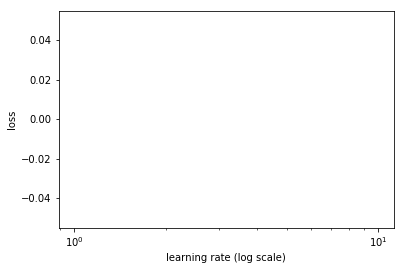

In [376]:
learn.lr_find()
learn.sched.plot()

In [377]:
lr=4e-2
# lr=4e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [378]:
learn.fit(lr,1,wds=wd,cycle_len=15,use_clr=(5,8))

epoch      trn_loss   val_loss   new_acc    dice_mult      
    0      0.402346   0.407063   0.840742   1.556452  
    1      0.219819   0.103947   0.963391   1.824972       
  0%|          | 0/15 [00:00<?, ?it/s]
    2      0.153523   0.088421   0.970224   1.837791       
    3      0.121306   0.056891   0.979507   1.890386       
    4      0.100513   0.051132   0.982238   1.901773       
    5      0.086036   0.052095   0.981213   1.896047        
    6      0.076089   0.046799   0.983257   1.905736        
    7      0.068694   0.045762   0.983979   1.909888        
    8      0.063229   0.045918   0.983701   1.908197        
    9      0.059351   0.046168   0.983397   1.907173        
    10     0.05587    0.045564   0.984065   1.911569        
    11     0.053125   0.043957   0.984387   1.910517        
    12     0.051281   0.04388    0.984504   1.911001        
    13     0.050056   0.044571   0.984166   1.909626        
    14     0.048934   0.044488   0.983831   1.906716     

[array([0.04449]), 0.9838314032554627, 1.9067158390472918]

In [379]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [380]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [381]:
learn.unfreeze()
learn.bn_freeze(True)

In [382]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.044318   0.046075   0.983835   1.908362  
    1      0.044236   0.044173   0.983644   1.907371        
    2      0.043455   0.043714   0.98373    1.907546        
    3      0.0428     0.042109   0.984858   1.913794        
    4      0.042546   0.041235   0.984924   1.913085        
    5      0.042024   0.044083   0.983573   1.906418        
    6      0.041315   0.041633   0.984825   1.91246         
    7      0.040883   0.041526   0.98463    1.911407        
    8      0.040955   0.040651   0.984972   1.913048        
    9      0.040653   0.040716   0.984816   1.912226        



[array([0.04072]), 0.9848155403137206, 1.9122259539285844]

In [383]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.040378   0.051797   0.982053   1.900846  
    1      0.041819   0.043168   0.984117   1.909089        
    2      0.041081   0.042106   0.985022   1.913525        
    3      0.040536   0.043228   0.984415   1.910647        
    4      0.040132   0.041903   0.985254   1.914415        
    5      0.039808   0.041138   0.984607   1.910959        
    6      0.039577   0.040473   0.98461    1.910572        
    7      0.039051   0.041096   0.985137   1.913783        
    8      0.038785   0.040028   0.985475   1.915301        
    9      0.038871   0.040151   0.985342   1.914236        



[array([0.04015]), 0.9853418087959289, 1.9142356317633613]

In [384]:
learn.save(f'128urn-{S_PREFIX}-0')

In [385]:
learn.load(f'128urn-{S_PREFIX}-0')

In [386]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [387]:
py = np.argmax(py,1)

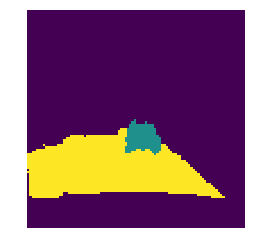

In [388]:
show_img(py[0]);

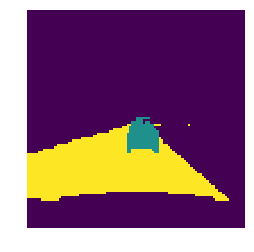

In [389]:
show_img(y[0]);

## 256x256

In [392]:
TRAIN_DN = 'CameraRGB-300'
MASKS_DN = 'CameraSeg-300'
sz=192
bs=64

In [393]:
md = get_data(TRAIN_DN, MASKS_DN, bs, sz)

In [394]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [395]:
learn = get_learner(md)

In [396]:
learn.freeze_to(1)

In [397]:
learn.load(f'128urn-{S_PREFIX}-0')

In [398]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.043125   0.019058   0.993282   1.948075  
    1      0.038094   0.02068    0.992791   1.946546        
    2      0.034947   0.018381   0.993426   1.94776         
    3      0.033537   0.019585   0.992852   1.947097        
    4      0.033089   0.022775   0.992046   1.94143         
    5      0.032764   0.019008   0.993286   1.946497        
    6      0.031924   0.01762    0.993807   1.949548        
    7      0.030837   0.016516   0.994085   1.950153        
    8      0.02975    0.016589   0.994131   1.950152        
    9      0.028904   0.016667   0.994114   1.950132        



[array([0.01667]), 0.994114317893982, 1.950131671608301]

In [399]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [400]:
learn.unfreeze()
learn.bn_freeze(True)

In [401]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [402]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.024427   0.016356   0.99405    1.94986   
    1      0.02469    0.016606   0.994024   1.951012        
    2      0.024806   0.016748   0.993856   1.949086        
    3      0.024774   0.01621    0.994158   1.950449        
    4      0.024624   0.016434   0.993986   1.949824        
    5      0.024506   0.016221   0.99413    1.950171        
    6      0.024375   0.016001   0.994233   1.950852        
    7      0.024274   0.016037   0.994208   1.950547        



[array([0.01604]), 0.9942078924179077, 1.9505474885673322]

In [403]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.023819   0.016589   0.993825   1.949282  
    1      0.023838   0.016009   0.994039   1.949532        
    2      0.024306   0.016207   0.99416    1.95122         
    3      0.023888   0.016129   0.994163   1.949784        
    4      0.024001   0.016576   0.993853   1.949525       
    5      0.023925   0.015834   0.994054   1.949298        
    6      0.023707   0.015725   0.99417    1.950099        
    7      0.023649   0.015812   0.994214   1.951008        



[array([0.01581]), 0.9942136025428772, 1.951007804289744]

In [404]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [405]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [406]:
py = np.argmax(py,1)

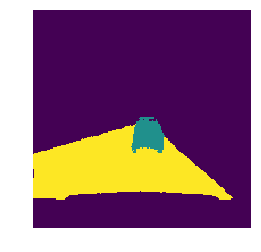

In [407]:
show_img(py[0]);

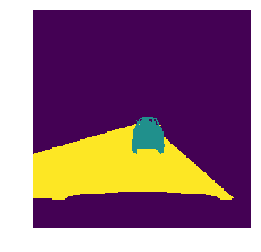

In [408]:
show_img(y[0]);

In [ ]:
m.close()

## 512x512

In [411]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz=288
bs=16

In [413]:
md = get_data(TRAIN_DN, MASKS_DN, bs, sz)

In [414]:
learn = get_learner(md)

In [415]:
learn.load(f'256urn-{S_PREFIX}')

In [416]:
learn.freeze_to(1)

In [417]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [418]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.031935   0.019512   0.993302   1.944986  
    1      0.033081   0.044311   0.984281   1.903807        
    2      0.027339   0.016322   0.993954   1.947948        
    3      0.027595   0.015455   0.994385   1.949511        



[array([0.01545]), 0.9943847632408143, 1.9495107879098992]

In [419]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [420]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [421]:
learn.unfreeze()
learn.bn_freeze(True)

In [422]:
lrs = np.array([lr/200,lr/30,lr])

In [423]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.021105   0.01422    0.99465    1.95107   
    1      0.02049    0.013542   0.994892   1.951759        
    2      0.019804   0.013535   0.994893   1.952252        
    3      0.019655   0.013467   0.994928   1.952228        



[array([0.01347]), 0.9949284958839416, 1.952227613452233]

In [424]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.019481   0.013709   0.994874   1.95157   
    1      0.019005   0.013442   0.994916   1.951722        
    2      0.018685   0.013052   0.99508    1.95272         
    3      0.018531   0.013001   0.995079   1.952627        



[array([0.013]), 0.9950788378715515, 1.952627053146944]

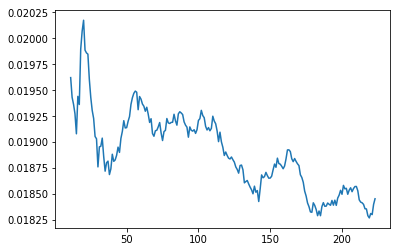

In [425]:
learn.sched.plot_loss()

In [426]:
learn.save(f'600urn-{S_PREFIX}')

In [427]:
learn.load(f'600urn-{S_PREFIX}')

In [428]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

TypeError: Invalid dimensions for image data

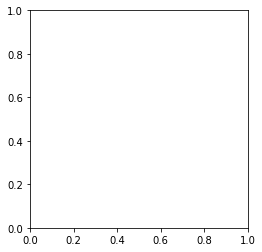

In [429]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);

## Save results

In [430]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [435]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [436]:
# model_summary(m, [3,608,800])

In [437]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [434]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()